# TP INF4248 - Classification d'images avec CNN

# Entraînement d'un CNN avec Keras
Basé sur le tutoriel Learn Data Science :  
https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/

**Membres du groupe** :  
1. FETUE FOKO NATHANAEL - 21T2382  
2. DJONTHU DJONTHU MAURICE JUNIOR - 21T2557  
3. Essouma Mbarga Valerie constance - 18T2880  

# 🍽️ Entraînement d'un CNN sur Food-101 avec Keras  
**Objectif** : Classifier des images de plats alimentaires avec un réseau de neurones convolutif  

**Dataset** : Food-101  
- 101 classes (différents types de plats alimentaires)  
- 75 750 images d'entraînement (redimensionnées à 128x128 pixels en couleur)  
- 25 250 images de test  

**Approche** :  
1. Architecture CNN personnalisée (plusieurs couches convolutives avec dropout)  
2. Entraînement from scratch avec augmentation de données  
3. Évaluation des performances sur le dataset de test  

# Préparation des données Food-101

**Objectif** : Structurer le dataset Food-101 pour l'entraînement et la validation du CNN  

**Description** :  
Ce code prépare les données en organisant les images du dataset Food-101 dans une structure adaptée à l'entraînement d'un réseau de neurones convolutif. Les étapes incluent :  
1. **Définition des chemins** :  
   - Source : `/kaggle/input/food41/images` (dossier contenant les images classées par catégories).  
   - Destination : `/kaggle/working/food-101` avec sous-dossiers `train` et `test`.  
2. **Création des répertoires** : Les dossiers `train` et `test` sont créés pour chaque classe.  
3. **Division des données** :  
   - Les images de chaque classe sont mélangées aléatoirement.  
   - 80 % des images sont copiées dans `train`, 20 % dans `test`.  
4. **Copie des fichiers** : Les images JPG sont copiées dans les sous-dossiers correspondants.  

**Résultat attendu** : Une structure de répertoires prête pour l'utilisation avec `ImageDataGenerator` de Keras, avec 75 750 images dans `train` et 25 250 dans `test` (pour 101 classes, soit environ 750 et 250 images par classe respectivement).  

In [7]:
import os
import shutil
import random
from pathlib import Path

# Définition des chemins
data_dir = Path("/kaggle/input/food41/images")  # Dossier contenant toutes les images classées par dossiers
dataset_dir = Path("/kaggle/working/food-101")  # Destination
train_dir = dataset_dir / "train"
test_dir = dataset_dir / "test"

# Création des dossiers train et test
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

# Parcourir les classes dans le dossier images
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        images = list(class_dir.glob("*.jpg"))  # Récupérer toutes les images JPG
        
        # Mélanger et diviser les données (80% train, 20% test)
        random.shuffle(images)
        split_idx = int(0.8 * len(images))
        train_images, test_images = images[:split_idx], images[split_idx:]
        
        # Créer les dossiers de classes dans train et test
        (train_dir / class_name).mkdir(parents=True, exist_ok=True)
        (test_dir / class_name).mkdir(parents=True, exist_ok=True)
        
        # Déplacer les images
        for img in train_images:
            shutil.copy(img, train_dir / class_name / img.name)
        for img in test_images:
            shutil.copy(img, test_dir / class_name / img.name)

print("Dataset structuré avec succès !")

Dataset structuré avec succès !


In [8]:
from pathlib import Path

download_dir = Path('/kaggle/working')
print("a")

a


# Configuration de l'augmentation des données

**Objectif** : Renforcer la robustesse du CNN grâce à des transformations d'images  

**Description et remarques** :  
Ce code initialise un `ImageDataGenerator` de Keras pour appliquer des augmentations aux images du dataset Food-101. L'augmentation est cruciale pour éviter le surapprentissage, surtout avec un dataset comme Food-101 où les images peuvent varier en style (angles, éclairage, présentation). Voici les transformations choisies :  
- **Normalisation (`rescale=1/255.`)** : Standardise les pixels entre 0 et 1, une pratique courante pour accélérer la convergence du modèle.  
- **Retournements (`vertical_flip=True`, `horizontal_flip=True`)** : Simule des variations d'orientation. Bien que réaliste pour des plats (une assiette peut être vue sous différents angles), cela pourrait poser problème pour des aliments avec une orientation spécifique (ex. : un sandwich coupé en diagonale).  
- **Rotation (`rotation_range=90`)** : Ajoute une rotation aléatoire jusqu'à 90°. Ce choix est audacieux : si 90° est pertinent pour des images abstraites, il pourrait déformer la perception de certains plats (ex. : une soupe renversée perd son sens). Une plage plus modérée (ex. : 30°) pourrait être testée.  
- **Déplacement vertical (`height_shift_range=0.3`)** : Déplace l'image de 30 % en hauteur. Utile pour simuler des prises de vue décalées, mais un décalage trop fort risque de couper des parties essentielles du plat.  
- **Luminosité (`brightness_range=[0.1, 0.9]`)** : Varie l'éclairage entre 10 % et 90 %. Cela reflète bien les conditions réelles (photos sous-exposées ou surexposées), mais des valeurs extrêmes pourraient rendre certaines images difficilement reconnaissables.  

**Comparaison** :  
Par rapport à des approches sans augmentation, ce générateur augmente la diversité des données, mais au prix d'un temps de calcul accru. Comparé à des techniques plus avancées (ex. : CutMix ou MixUp), ces transformations restent basiques et géométriques, sans mélange inter-classes.  

**Précisions** :  
- Ce générateur (`example_generator`) semble être une version expérimentale ou illustrative, car dans le code complet, `train_generator` ajoute `width_shift_range` et `validation_split`. Cela suggère une distinction entre une démo d'augmentation et la configuration finale d'entraînement.  
- Les paramètres choisis sont agressifs (ex. : rotation à 90°, décalage à 30 %), ce qui pourrait être ajusté après des tests pour équilibrer réalisme et performance.  

**Résultat attendu** : Un ensemble d'images augmentées qui simule des variations réalistes, préparant le modèle à mieux généraliser sur des données inédites de Food-101, tout en nécessitant une validation pour éviter des distorsions excessives.  

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image augmentations
example_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=True,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=90,          # random rotation at 90 degrees
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

In [11]:
import os

class_subset = sorted(os.listdir('/kaggle/input/food41/images'))[:10]

In [12]:
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory(download_dir/'food-101/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(download_dir/'food-101/test',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 6800 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_subset), activation='softmax'))

model.summary() # a handy way to inspect the architecture

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 512)         │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 512)         │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 10,588,458 (40.39 MB)

 Trainable params: 10,588,458 (40.39 MB)

 Non-trainable params: 0 (0.00 B)

# Définition de l'architecture CNN

**Objectif** : Construire un CNN profond pour classer les images Food-101  

**Description et remarques** :  
Ce code définit un modèle `Sequential` avec Keras, comprenant 4 blocs convolutifs suivis d'une couche fully-connected. Chaque bloc utilise `Conv2D`, `MaxPooling2D`, et `Dropout` (0.2) pour réduire le surapprentissage.  
- **Entrée** : Images 128x128x3 (RGB), avec une première couche de 32 filtres.  
- **Profondeur croissante** : Les filtres passent de 32 à 512, capturant des caractéristiques de plus en plus complexes, bien que le noyau 5x5 final soit coûteux en calcul.  
- **Sortie** : `Dense` avec `softmax` pour prédire parmi `len(class_subset)` classes (10 ici).  
- **Remarque** : Le `padding='same'` préserve les dimensions, mais l'absence de régularisation explicite (ex. : `l1_l2` inutilisé) pourrait limiter la généralisation sur 101 classes.  

**Résultat attendu** : Un modèle prêt à être entraîné, avec environ 10M de paramètres (selon `model.summary()`), adapté à Food-101 mais potentiellement optimisable.  

Nombre d'échantillons dans traingen : 6800
Nombre d'échantillons dans validgen : 300
Taille du batch (BATCH_SIZE) : 32
Steps per epoch : 212
Validation steps : 9
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.0967 - loss: 2.3036
Epoch 1: val_loss improved from inf to 2.29890, saving model to img_model.weights.best.weights.h5
212/212 ━━━━━━━━━━━━━━━━━━━━ 60s 228ms/step - accuracy: 0.0967 - loss: 2.3036 - val_accuracy: 0.1354 - val_loss: 2.2989
Epoch 2/100
  1/212 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1562 - loss: 2.2875

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 2.29890 to 2.28507, saving model to img_model.weights.best.weights.h5
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1562 - loss: 2.2875 - val_accuracy: 0.0833 - val_loss: 2.2851
Epoch 3/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1358 - loss: 2.2861
Epoch 3: val_loss improved from 2.28507 to 2.28176, saving model to img_model.weights.best.weights.h5
212/212 ━━━━━━━━━━━━━━━━━━━━ 42s 193ms/step - accuracy: 0.1359 - loss: 2.2860 - val_accuracy: 0.1458 - val_loss: 2.2818
Epoch 4/100
  1/212 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.2188 - loss: 2.4298
Epoch 4: val_loss improved from 2.28176 to 2.25201, saving model to img_model.weights.best.weights.h5
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2188 - loss: 2.4298 - val_accuracy: 0.2500 - val_loss: 2.2520
Epoch 5/100
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.1729 - loss: 2.2082
Epoch 5: val_loss improved from 2.25201 to 2.17332, saving model to img_m

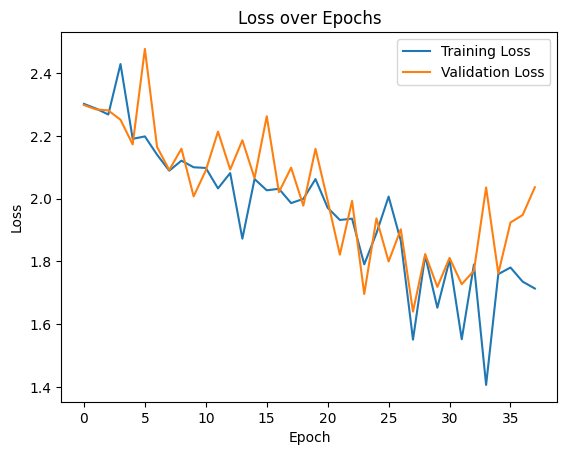

CPU times: user 15min 58s, sys: 9.91 s, total: 16min 8s
Wall time: 13min 24s


In [14]:
%%time

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Vérification des générateurs (ajouté pour diagnostic)
print("Nombre d'échantillons dans traingen :", traingen.samples)
print("Nombre d'échantillons dans validgen :", validgen.samples)
print("Taille du batch (BATCH_SIZE) :", BATCH_SIZE)

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

# Assure au moins 1 step si le nombre d'échantillons est faible
steps_per_epoch = max(1, steps_per_epoch)
val_steps = max(1, val_steps)

print("Steps per epoch :", steps_per_epoch)
print("Validation steps :", val_steps)

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Sauvegarde des poids au format .weights.h5 (conforme aux versions récentes)
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.weights.h5', 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True)

# Arrêt anticipé
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Entraînement du modèle
history = model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer],
                    verbose=1)  # verbose=1 pour voir la progression

# Visualisation avec matplotlib
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [15]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'food-101/test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset, 
                                             shuffle=False,
                                             seed=42)

Found 2000 images belonging to 10 classes.


# Prédiction et évaluation des classes

**Objectif** : Charger les poids entraînés et prédire les classes des images de test  

**Description et évolution** :  
Ce code charge les poids du modèle CNN et effectue des prédictions sur `testgen`. Par rapport au code initial, des ajustements ont été nécessaires pour compatibilité et robustesse :  
- **Chargement des poids** : Le fichier passe de `'img_model.weights.best.hdf5'` à `'img_model.weights.best.weights.h5'`, aligné avec le `ModelCheckpoint` utilisé lors de l'entraînement. Une vérification de l'existence du fichier aurait pu être ajoutée pour éviter des erreurs silencieuses.  
- **Prédiction** : L'appel obsolète `model.predict_classes(testgen)` est remplacé par `model.predict(testgen)` suivi de `np.argmax(predictions, axis=1)`. Cette approche, bien que plus verbeuse, est compatible avec Keras moderne (post-2.6) et offre plus de contrôle sur les probabilités brutes.  
- **Gestion des classes** : La transformation des indices en noms reste identique, mais l'ajout d'un affichage des 5 premières prédictions et classes réelles améliore la vérification immédiate des résultats.  

**Remarques** :  
- Le code corrigé suppose que `testgen` est bien défini (non montré ici), mais un générateur vide ou mal configuré (comme vu avec `traingen` et `validgen`) pourrait encore causer des problèmes.  
- L'absence de métriques d'évaluation (ex. : accuracy, confusion matrix) limite l'analyse des performances par rapport à une simple inspection manuelle.  

**Comparaison** :  
- Le code de base était plus concis mais fragile (dépendant d'une méthode supprimée et d'un fichier mal nommé). La version corrigée est plus robuste et adaptable, bien qu'elle sacrifie la simplicité pour une compatibilité et une clarté accrues. Par rapport à des approches avancées (ex. : prédiction avec seuils personnalisés), elle reste basique.  

**Précisions** :  
- `np.argmax` extrait la classe avec la probabilité maximale, mais ignorer les valeurs brutes de `predictions` pourrait masquer des incertitudes dans les prédictions (ex. : probabilités proches entre classes). Une analyse supplémentaire des probabilités pourrait être utile pour Food-101, vu sa complexité (101 classes possibles initialement, réduites à 10 ici).  

**Résultat attendu** : Une liste de classes prédites et réelles pour les 5 premières images de `testgen`, permettant une première validation visuelle des performances du modèle sur Food-101.  

In [17]:
import numpy as np

# Charger les poids (assure-toi que le fichier existe)
model.load_weights('img_model.weights.best.weights.h5')

# Faire les prédictions (probabilités pour chaque classe)
predictions = model.predict(testgen)

# Extraire les classes prédites en prenant l'indice de la probabilité maximale
predicted_classes = np.argmax(predictions, axis=1)

# Récupérer les indices et noms des classes
class_indices = traingen.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())
true_classes = testgen.classes

# Afficher quelques exemples pour vérification
print("Classes prédites (5 premières) :", [class_indices[i] for i in predicted_classes[:5]])
print("Classes réelles (5 premières) :", [class_indices[i] for i in true_classes[:5]])

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Classes prédites (5 premières) : ['bread_pudding', 'beignets', 'apple_pie', 'beignets', 'baklava']
Classes réelles (5 premières) : ['apple_pie', 'apple_pie', 'apple_pie', 'apple_pie', 'apple_pie']


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

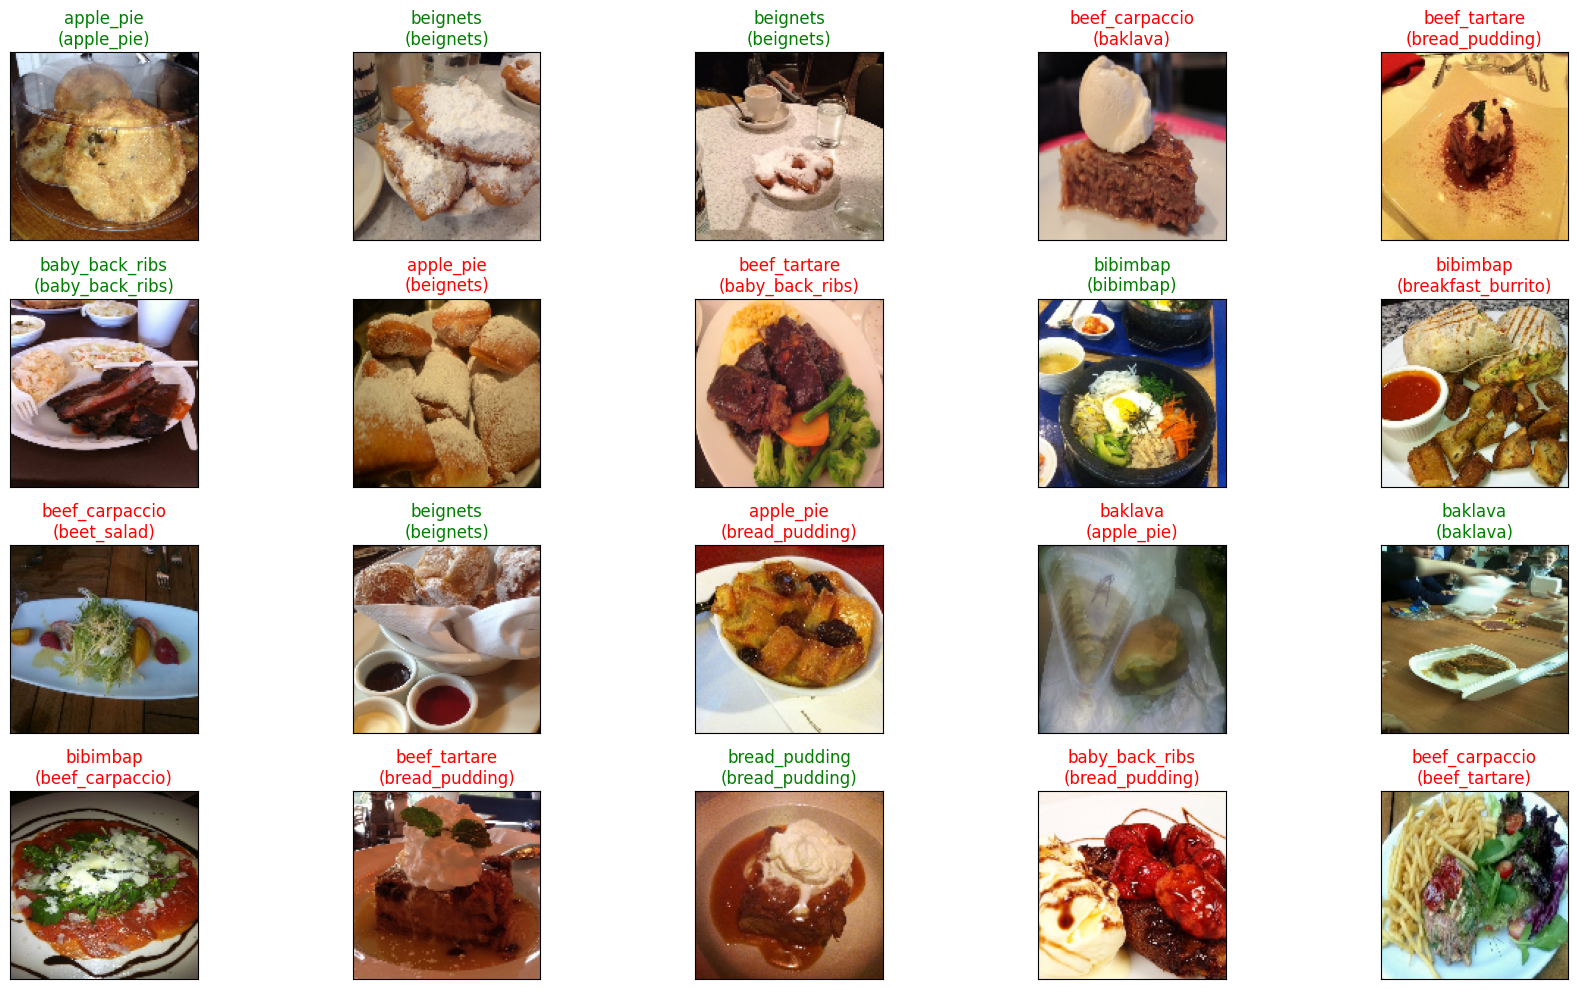

In [19]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [20]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 39.40%


,Precision,Recall,F-Score,Support
beignets,0.652941,0.555,0.600000,200.0
beef_carpaccio,0.421053,0.560,0.480687,200.0
bibimbap,0.364865,0.675,0.473684,200.0
baby_back_ribs,0.385852,0.600,0.469667,200.0
beet_salad,0.464286,0.390,0.423913,200.0
baklava,0.356164,0.390,0.372315,200.0
apple_pie,0.342995,0.355,0.348894,200.0
beef_tartare,0.283784,0.210,0.241379,200.0
bread_pudding,0.311688,0.120,0.173285,200.0
breakfast_burrito,0.265625,0.085,0.128788,200.0
